In [89]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import cmath
# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'w'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 8
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 800
# plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['image.cmap'] = 'viridis'

res = 400
MC_N = int(1e4)
peakVals = 1

# parameters

In [90]:
Delta_ZPL_0 = 406.83  # 406 THz  Meesala
lambda_SO_gs = 46e-3  # 46 GHz  Meesala
lambda_SO_es = 255e-3  # 255 GHz  Meesala

t_para = -1.7e3  # -1.7 PHz/strain  Meesala
t_perp = 0.078e3  # 0.078 PHz/strain   Meesala
d_gs = 1.3e3  # 1.3 PHz/strain   Meesala
d_es = 1.8e3  # 1.8 PHz/strain   Meesala
f_gs = -1.7e3  # -1.7 PHz/strain   Meesala
f_es = -3.4e3 # -3.4 PHz/strain   Meesala

StdDev = 5e-3 # Kelsey
gamma_10 = 1.33e-3  # 28 GHz p.3 or 1.33 Ghz p.5 Smallwood PRL
# gamma_10 = 1e-4 # fwhm = 10e-3 Kelsey

poi = -0.2  # Poisson ratio of diamond, Kelsey

nu_t = np.linspace(402.25, 409.5, res)
nu_tau = np.linspace(-409.5, -402.25, res)

# nu_t = np.linspace(405.5, 408.75, res)
# nu_tau = np.linspace(-408.75, -405.5, res)

# nu_t = np.linspace(-0.5, 0.5, res)
# nu_tau = np.linspace(-0.5, 0.5, res)

# colorbar function

In [91]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

# creating mesh

In [92]:
nu_t_mesh, nu_tau_mesh = np.meshgrid(nu_t, nu_tau, indexing='xy')

# multiple plot function

In [93]:
# @numba.jit
def slices_plots(
    databox,
    titles=None,
    figure_shape=[4, 4],
    figure_size=(11, 10),
    vertical_gap=0.15,
    horizontal_gap=0.15,
    shared_x_label=r'Third-order frequency, $\nu_t$ (THz)',
    shared_x_label_x_position=0.515,
    shared_x_label_y_position=0.09,
    shared_y_label=r'First-order frequency, $\nu_\tau$ (THz)',
    shared_y_label_x_position=0.08,
    shared_y_label_y_position=0.5,
    shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\nu_t, \nu_\tau) \right\}$',
    shared_title_x_position=0.515,
    shared_title_y_position=0.93,
    share_x_axis=True,
    share_y_axis=True,
    colorbar_labels='arb. units',
    EXTENT=(min(nu_t), max(nu_t), min(nu_tau), max(nu_tau))):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(databox[i],
                                    origin='lower',
                                    extent=EXTENT)
        ax.flatten()[i].set_title(titles[i])

        if np.size(colorbar_labels) == 1:
            if (i + 1) % figure_shape[1]:
                colorbar(im, None)
            else:
                colorbar(im, colorbar_labels)
        else:
            colorbar(im, colorbar_labels[i])

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 size=1.5 * SIZE)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center')

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_position,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical')

    plt.show()
    return fig

# complex square function

In [94]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def abs2(x):

    return x.real**2. + x.imag**2.

# complex phase

In [95]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def phase(x):

    return cmath.phase(x)

In [96]:
@numba.jit
def Delta_ZPL(eps_xx=0., 
              eps_yy=0., 
              eps_zz=0.):
    
    return Delta_ZPL_0 + t_para*eps_zz + t_perp*(eps_xx + eps_yy)

In [97]:
@numba.jit
def Delta_gs(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_gs**2.,
            4. * (d_gs * (eps_xx - eps_yy) + f_gs * eps_yz)**2.,
            4. * (-2. * d_gs * eps_xy + f_gs * eps_zx)**2.
        ]))

In [98]:
@numba.jit
def Delta_es(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_es**2.,
            4. * (d_es * (eps_xx - eps_yy) + f_es * eps_yz)**2.,
            4. * (-2. * d_es * eps_xy + f_es * eps_zx)**2.
        ]))

In [99]:
@numba.jit
def rho(nu_t,
        nu_tau,
        eps_xx=0.,
        eps_yy=0.,
        eps_zz=0.,
        eps_yz=0.,
        eps_xy=0.,
        eps_zx=0.):

    Del_ZPL = Delta_ZPL(eps_xx, eps_yy, eps_zz)

    Del_gs = Delta_gs(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    Del_es = Delta_es(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    if peakVals:
    
        amp = np.array(
            [0.0938, 0.0833, 0.0579, 0.0576,
             0.0709, 1.0000, 0.0799, 0.1521, 
             0.0631, 0.0837, 0.3036, 0.0737, 
             0.0522, 0.1212, 0.0581, 0.1228])
    else:
    
        amp = np.array(
            [0., 1., 1., 1., 
             1., 1., 1., 1., 
             1., 1., 1., 1., 
             1., 1., 1., 1.])

    sign = np.array([[ 1.,  1.,  1.,  1.], 
                     [ 1.,  1.,  1., -1.], 
                     [ 1.,  1., -1.,  1.],
                     [ 1.,  1., -1., -1.], 
                     [ 1., -1.,  1.,  1.], 
                     [ 1., -1.,  1., -1.],
                     [ 1., -1., -1.,  1.], 
                     [ 1., -1., -1., -1.],
                     [-1.,  1.,  1.,  1.], 
                     [-1.,  1.,  1., -1.], 
                     [-1.,  1., -1.,  1.],
                     [-1.,  1., -1., -1.], 
                     [-1., -1.,  1.,  1.],
                     [-1., -1.,  1., -1.], 
                     [-1., -1., -1.,  1.],
                     [-1., -1., -1., -1.]])

    RHO = 1.j * np.zeros(np.shape(nu_t))

    for i in range(np.shape(sign)[0]):
        t_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            nu_t - (Del_ZPL + sign[i, 0] * Del_gs + sign[i, 1] * Del_es -
                       1.j * gamma_10))
        tau_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            nu_tau + (Del_ZPL + sign[i, 2] * Del_gs + sign[i, 3] * Del_es +
                         1.j * gamma_10))

        RHO += t_Lorentz * tau_Lorentz

    return RHO

In [100]:
@numba.jit
def eps_xx_p(eps_zz_0, 
             theta,
             phi):
    
    return ( poi*np.cos(phi)**2. + np.sin(phi)**2.*(poi*np.cos(theta)**2. + np.sin(theta)**2.) )*eps_zz_0

In [101]:
@numba.jit
def eps_yy_p(eps_zz_0, 
             theta,
             phi):
    
    return ( poi*np.sin(phi)**2. + np.cos(phi)**2.*(poi*np.cos(theta)**2. + np.sin(theta)**2.) )*eps_zz_0

In [102]:
@numba.jit
def eps_zz_p(eps_zz_0, 
             theta,
             phi):
    
    return (np.cos(theta)**2. + poi*np.sin(theta)**2.)*eps_zz_0

In [103]:
@numba.jit
def eps_yz_p(eps_zz_0, 
             theta,
             phi):
    
    return (poi - 1.) * np.cos(phi) * np.sin(2.*theta)/2. * eps_zz_0

In [104]:
@numba.jit
def eps_xy_p(eps_zz_0, 
             theta,
             phi):
    
    return (poi - 1.) * np.sin(2.*phi)/2. * np.sin(theta)**2. * eps_zz_0

In [105]:
@numba.jit
def eps_zx_p(eps_zz_0, 
             theta,
             phi):
    
    return (1. - poi) * np.sin(phi) * np.sin(2.*theta)/2. * eps_zz_0

In [106]:
@numba.jit
def randDir_MCint(
        nu_t=nu_t,
        nu_tau=nu_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps_zz_0 = StdDev * np.random.randn(MC_N)  # normal distribution
    rand_theta = np.arccos(
        2. * np.random.rand(MC_N) -
        1.)  # dcos(theta) uniform distribution, not theta unifrom
    rand_phi = 2. * np.pi * np.random.rand(MC_N)

    I_randDir = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over nu mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(nu_t):
            for j, om_tau in enumerate(nu_tau):
                I_randDir[j, i] = np.mean(
                    rho(om_t,
                        om_tau,
                        eps_xx=eps_xx_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_yy=eps_yy_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_zz=eps_zz_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_yz=eps_yz_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_xy=eps_xy_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_zx=eps_zx_p(randn_eps_zz_0, rand_theta, rand_phi)))
                
    else:
        
        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_randDir += rho(nu_t_mesh, 
                             nu_tau_mesh,
                             eps_xx=eps_xx_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_yy=eps_yy_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_zz=eps_zz_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_yz=eps_yz_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_xy=eps_xy_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_zx=eps_zx_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]))
    
    return I_randDir / np.sqrt(np.max(abs2(I_randDir)))

In [107]:
I_randomDir = randDir_MCint()

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_2542/1009786551.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "randDir_MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7fab87dff310>)) with parameters (float64, float64, eps_xx=array(float64, 1d, C), eps_xy=array(float64, 1d, C), eps_yy=array(float64, 1d, C), eps_yz=array(float64, 1d, C), eps_zx=array(float64, 1d, C), eps_zz=array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7fab87dff310>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_2542/1009786551.py (22)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_2542/1009786551.py", line 22:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_2542/1009786551.py:1: NumbaWarning: 
Compilation is falling back to obj

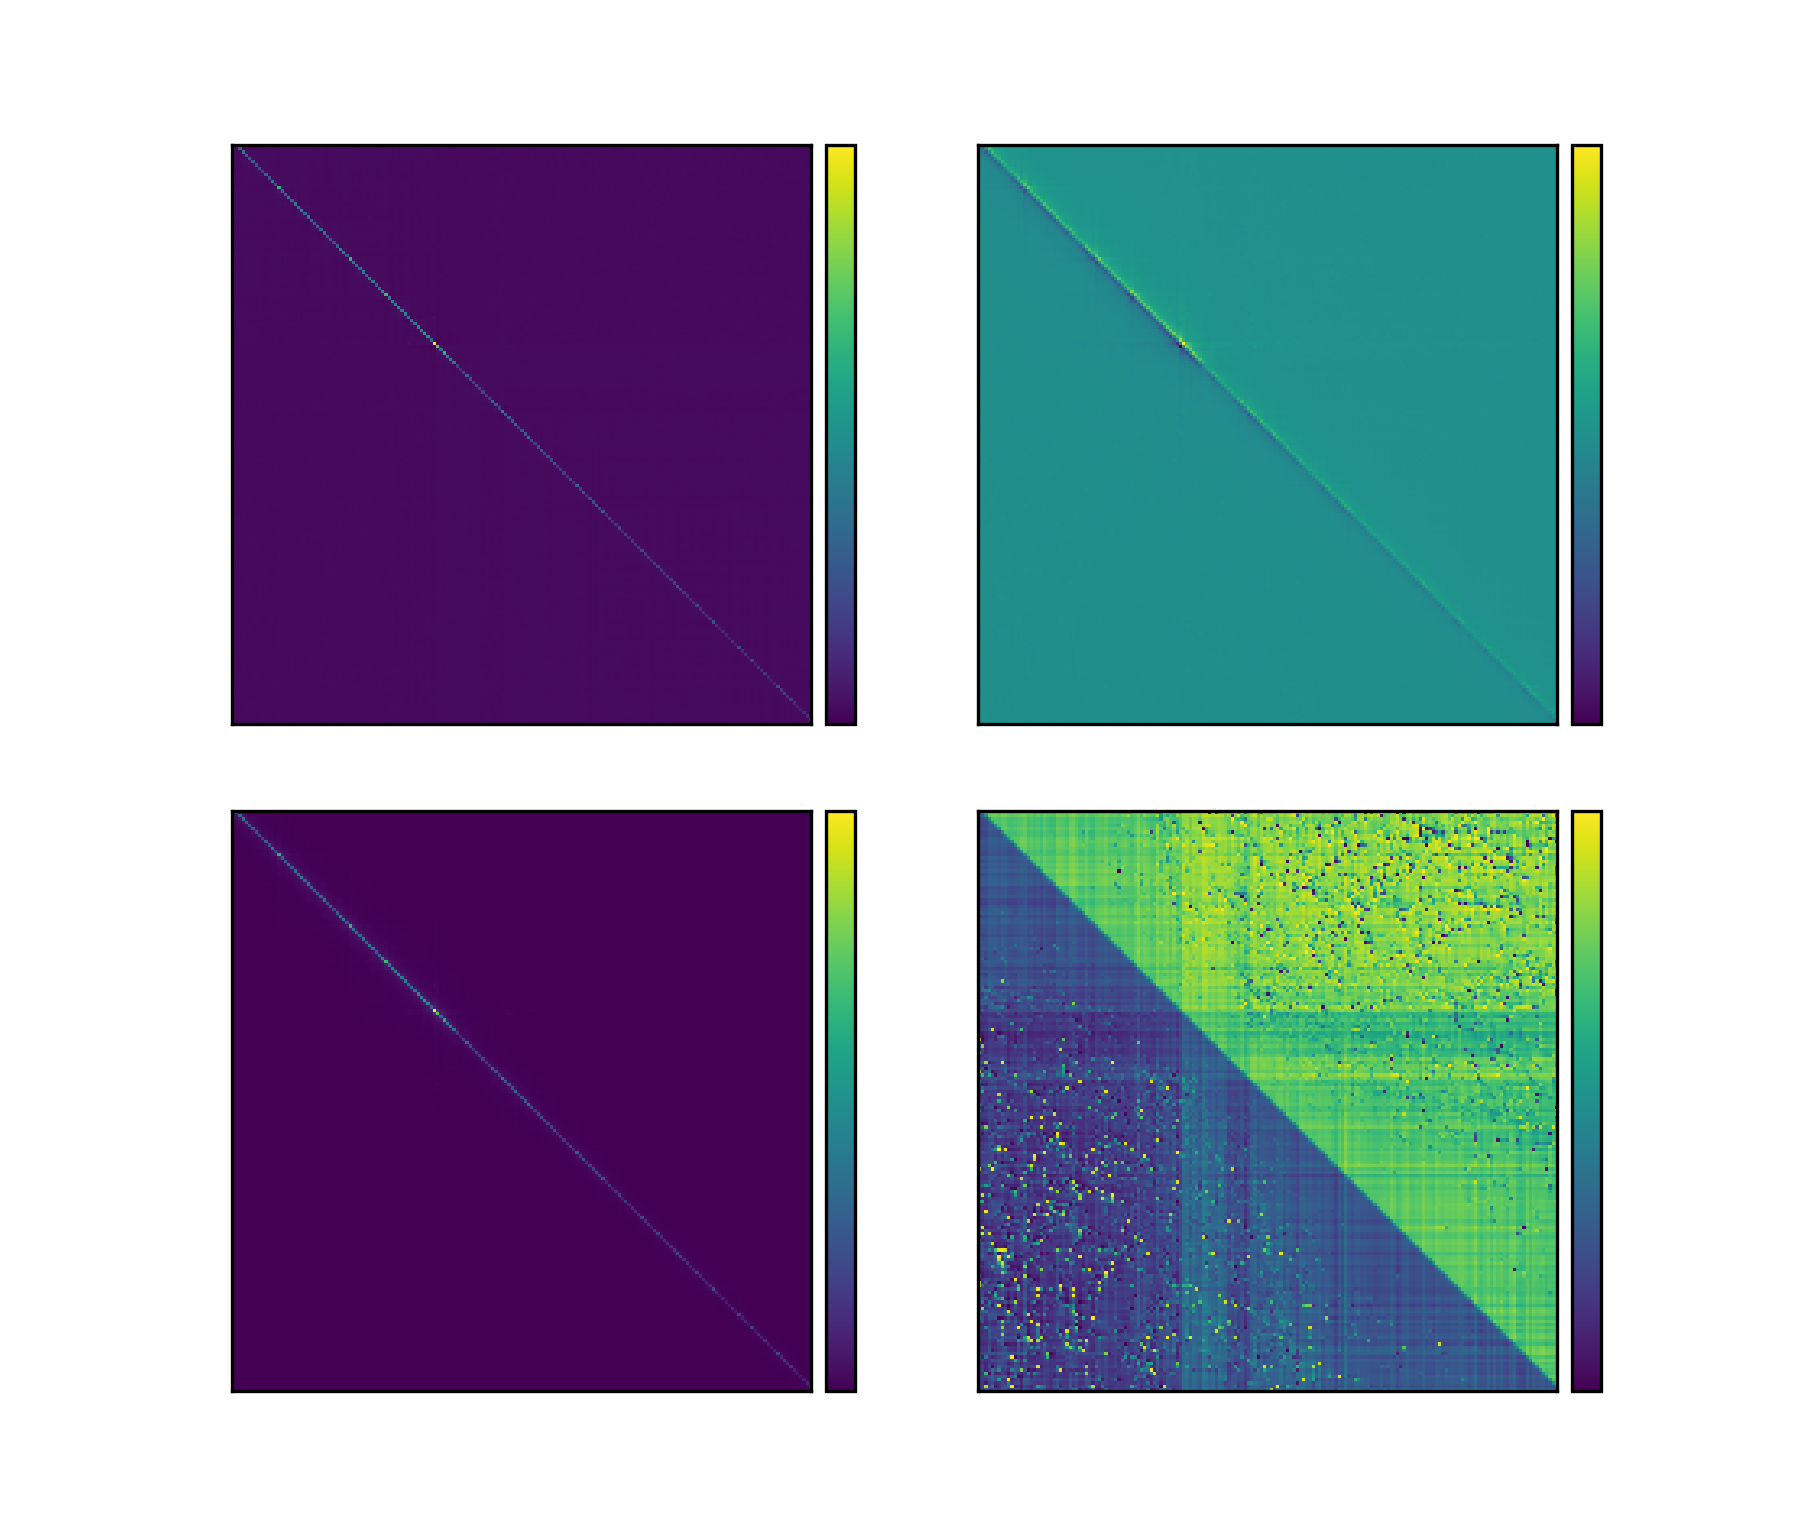

In [108]:
minPlt = 405.5   # THz
maxPlt = 408.75  # THz

minInd_t = np.argmin(np.abs(nu_t-minPlt))
maxInd_t = np.argmin(np.abs(nu_t-maxPlt))

minInd_tau = np.argmin(np.abs(nu_tau+maxPlt))
maxInd_tau = np.argmin(np.abs(nu_tau+minPlt))

I_randomDirPlt = I_randomDir[minInd_tau:maxInd_tau,minInd_t:maxInd_t]

I_randomDir_ReImAmPh = np.array([I_randomDirPlt.real, 
                               I_randomDirPlt.imag, 
                               np.sqrt(abs2(I_randomDirPlt)), 
                               phase(I_randomDirPlt)])

fig_randomDir = slices_plots(I_randomDir_ReImAmPh, 
                             shared_title='Random ' r'$\epsilon_{zz}$' ' in random directions, StdDev =' f'{StdDev:.0e}', 
                             shared_title_y_position=0.95,
                             figure_shape=[2,2], 
                             figure_size=[6,5.5],
                             titles=[r'$\mathfrak{R} \left\{I_{randDir} (\nu_t, \nu_\tau) \right\}$', 
                                     r'$\mathfrak{I} \left\{I_{randDir} (\nu_t, \nu_\tau) \right\}$',
                                     r'$             \left |I_{randDir} (\nu_t, \nu_\tau) \right |$',
                                     r'$     \varphi \left\{I_{randDir} (\nu_t, \nu_\tau) \right\}$'],
                             horizontal_gap=0.15,
                             shared_y_label_x_position=0.02, 
                             shared_x_label_y_position=0.06,
                             EXTENT=(nu_t[minInd_t], 
                                     nu_t[maxInd_t], 
                                     nu_tau[minInd_tau], 
                                     nu_tau[maxInd_tau])
                            )

In [109]:
I_randomDir_proj = np.sum(I_randomDir, axis=0)

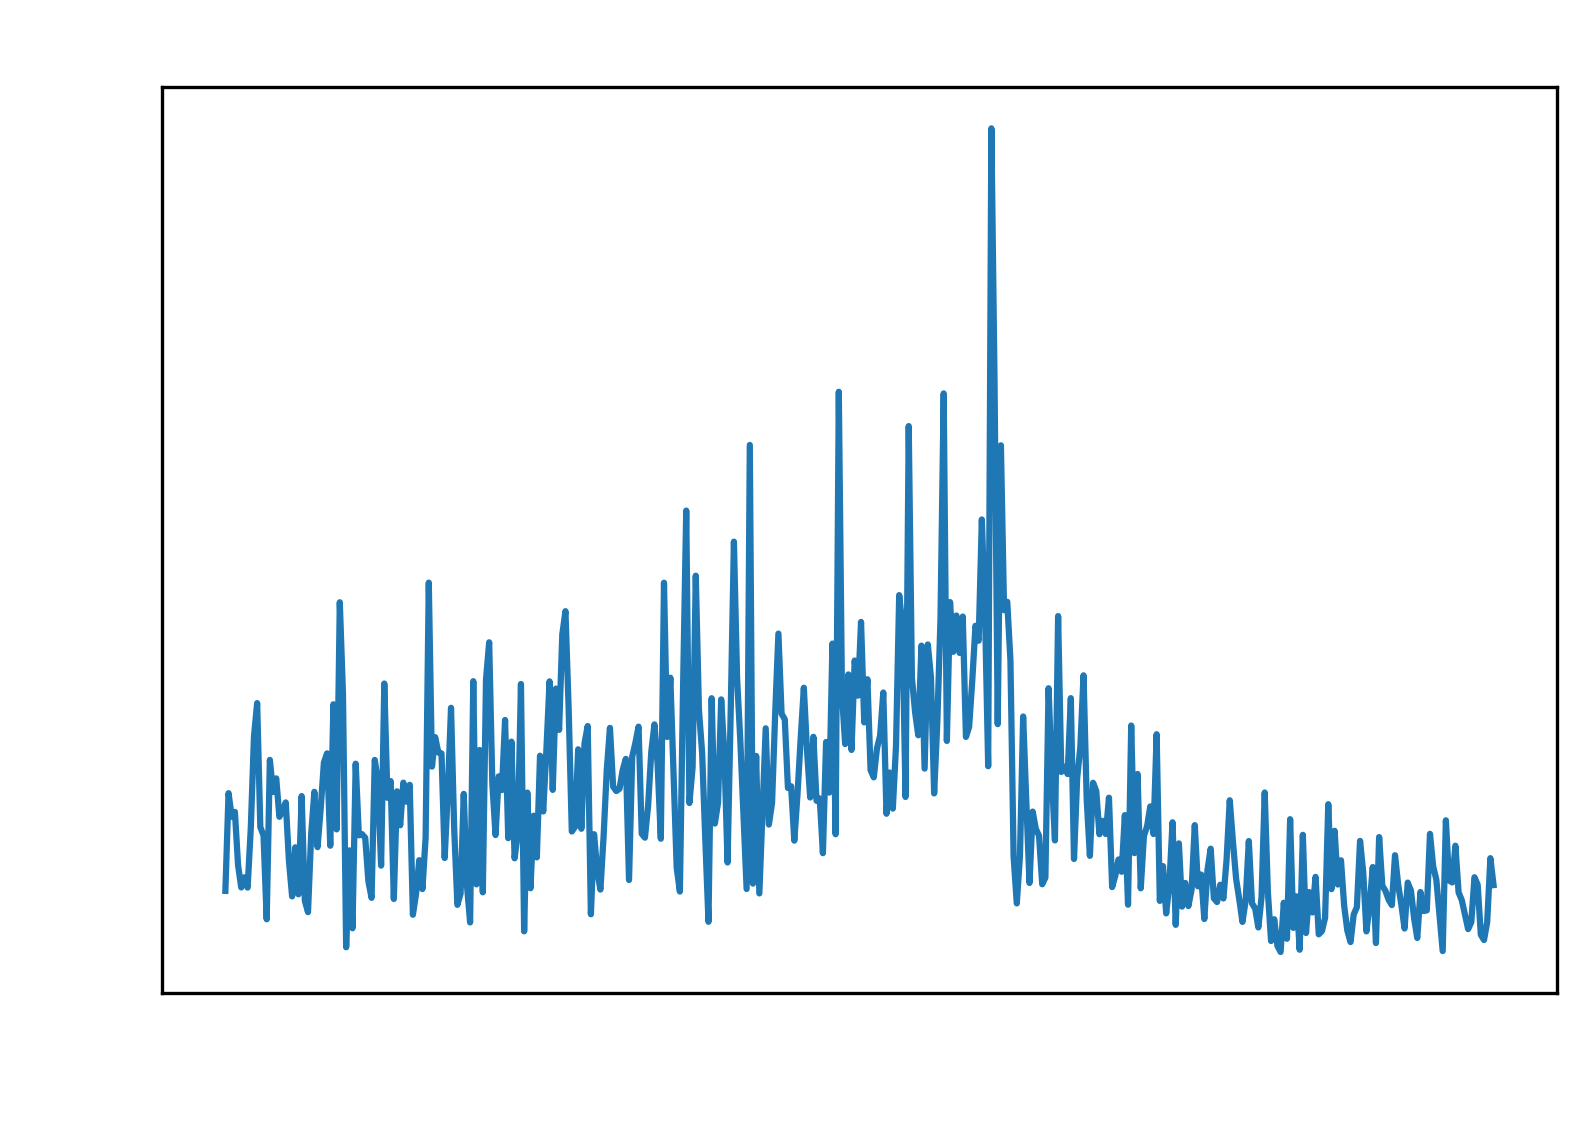

In [110]:
plt.figure()
plt.plot(nu_t, np.sqrt(abs2(I_randomDir_proj)))
plt.title(r'Projection of $\left |I_{rand6} (\nu_t, \nu_\tau) \right |$ onto $\nu_t$, StdDev =' f'{StdDev:.0e}')
plt.xlabel(r'Third-order frequency, $\nu_t$ (THz)')
plt.ylabel(r'Signal (arb. units)')
plt.show()